In [1]:
!pip install git+https://github.com/gaydaci/IIRPhaseNet.git


  Cloning https://github.com/gaydaci/IIRPhaseNet.git to /private/var/folders/by/dbtg3sh51592ksxb0q5db6hc0000gn/T/pip-req-build-eflwd9wi
  Running command git clone --filter=blob:none --quiet https://github.com/gaydaci/IIRPhaseNet.git /private/var/folders/by/dbtg3sh51592ksxb0q5db6hc0000gn/T/pip-req-build-eflwd9wi
  Resolved https://github.com/gaydaci/IIRPhaseNet.git to commit 6d48976e8ac896281d8ce39e0dd555257cade617
  Preparing metadata (setup.py) ... done
  Using cached torchaudio-2.2.2-cp39-cp39-macosx_10_13_x86_64.whl.metadata (6.4 kB)
  Using cached torch-2.2.2-cp39-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached frozenlist-1.5.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata (13 kB)
  Using cached multidict-6.1.0-cp39-cp39-macosx_10_9_x86_64.whl.metadata (5.0 kB)
Using cached torchaudio-2.2.2-cp39-cp39-macosx_10_13_x86_64.whl (3.4 MB)
Using cached torch-2.2.2-cp39-none-macosx_10_9_x86_64.whl (150.8 MB)
Using cached frozenlist-1.5.0-cp39-cp39-macosx_10_9_x86_64.whl (54 kB)
Us

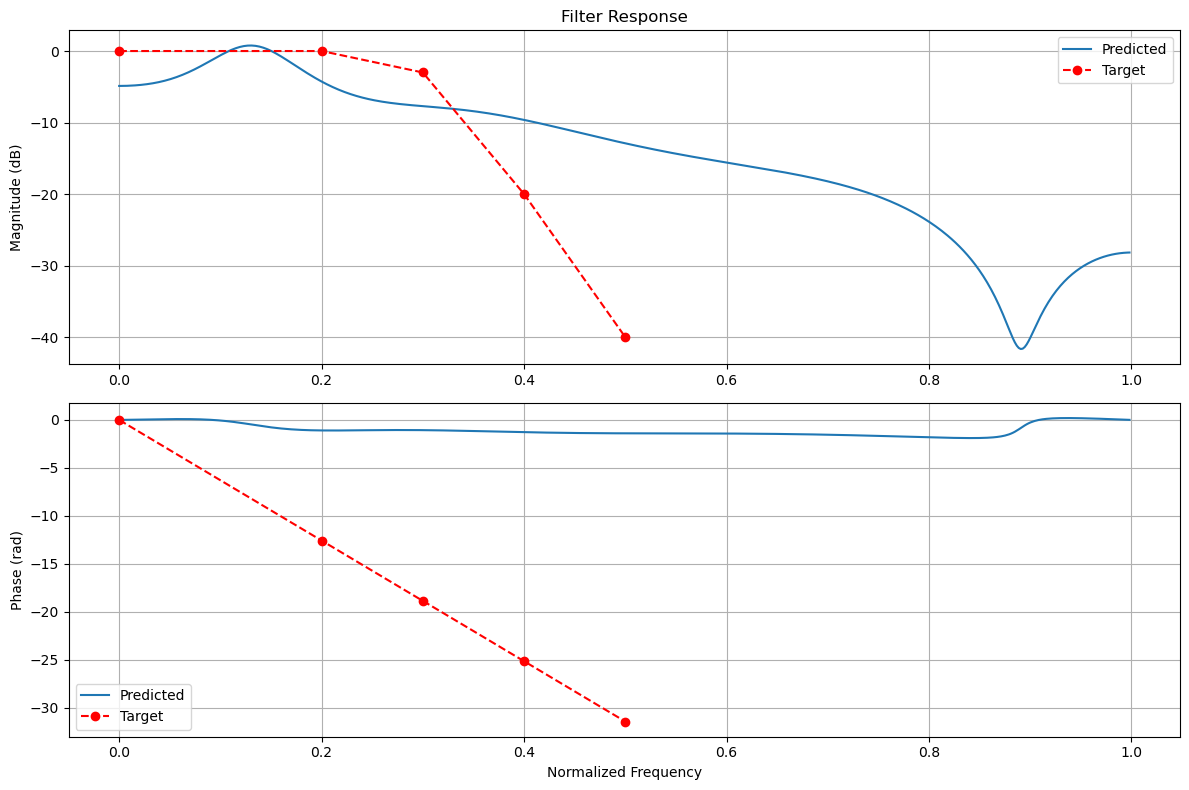

SOS Coefficients:
[[ 0.18648551 -0.281713    0.11057311  1.         -0.5567467   0.36899373]
 [ 1.          0.08319292  0.19306979  1.         -1.2511461   0.41417146]
 [ 1.          1.8074752   0.921171    1.          0.77670896  0.17436911]
 [ 1.         -1.124852    0.5115628   1.         -1.5793959   0.7425767 ]
 [ 1.         -0.06181337  0.13046975  1.          0.1944651   0.06105068]]


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from iirnet.mlp import MLPModel
import scipy.signal

def test_iirnet():
    # 1. Load saved model
    model_path = './trained_model.pt'  # Update path to your local model
    checkpoint = torch.load(model_path)
    
    model = MLPModel(
        num_points=checkpoint['num_points'],
        num_layers=checkpoint['args'].num_layers,
        hidden_dim=checkpoint['args'].hidden_dim,
        model_order=checkpoint['args'].model_order
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 2. Create test filter specs
    freq_points = np.array([0, 0.2, 0.3, 0.4, 0.5])
    mag_points = np.array([0, 0, -3, -20, -40])  # Lowpass filter
    phase_points = np.zeros_like(freq_points)  # Linear phase target
    
    # Generate target phase (linear phase example)
    target_delay = 10  # samples delay
    phase_points = -2 * np.pi * freq_points * target_delay

    # 3. Prepare input
    mag_input = torch.from_numpy(mag_points).float().view(1, -1)
    mag_input = torch.nn.functional.interpolate(
        mag_input.unsqueeze(0), 
        256
    ).squeeze(0)
    phase_input = torch.zeros_like(mag_input)

    # 4. Run inference
    with torch.no_grad():
        pred_sos, _ = model(mag_input, phase_input)


    # Enhanced plotting with phase
    w, h = scipy.signal.sosfreqz(pred_sos[0].numpy(), fs=2)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Magnitude plot
    ax1.plot(w, 20 * np.log10(np.abs(h)), label='Predicted')
    ax1.plot(freq_points, mag_points, 'ro--', label='Target')
    ax1.grid(True)
    ax1.legend()
    ax1.set_ylabel('Magnitude (dB)')
    ax1.set_title('Filter Response')
    
    # Phase plot
    phase = np.unwrap(np.angle(h))  # Unwrap phase for continuity
    ax2.plot(w, phase, label='Predicted')
    ax2.plot(freq_points, phase_points, 'ro--', label='Target')
    ax2.grid(True)
    ax2.set_ylabel('Phase (rad)')
    ax2.set_xlabel('Normalized Frequency')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    return pred_sos[0].numpy()

if __name__ == "__main__":
    sos = test_iirnet()
    print("SOS Coefficients:")
    print(sos)